In [37]:
import os
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.activations import relu
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.layers import BatchNormalization, Dense, Conv2D, Flatten, MaxPooling2D, Dropout
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
tqdm.pandas()

In [38]:
df = pd.read_csv('../data/fer2013.csv')

#### **DATA PREPROCESSING**

In [3]:
df['pixels'] = df['pixels'].progress_apply(lambda x: np.asarray(list(map(float, x.split()))).reshape((48,48,1))/255.0)

  0%|          | 0/35887 [00:00<?, ?it/s]

In [4]:
emotion_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [5]:
def plot_image(x, label):
    title = emotion_dict[label]
    x = np.array(x).reshape((48,48))
    plt.imshow(x)
    plt.title(title)
    plt.axis('off')


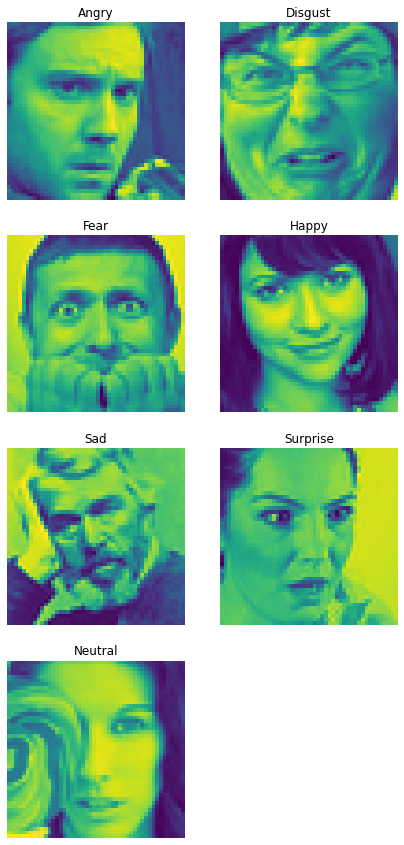

In [6]:
i = 0
j = 0

fig = plt.figure(figsize=(7, 15))
rows = 4
columns = 2


while(i<7):
    if(i == df['emotion'][j]):
        fig.add_subplot(rows, columns, i+1)
        plot_image(df['pixels'][j], df['emotion'][j])
        i+= 1
    j+=1
plt.show()

In [7]:
df_train = df[df['Usage'] == 'Training']
df_valid = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

In [8]:
len(df_train), len(df_valid), len(df_test)

(28709, 3589, 3589)

In [9]:
df_train = df_train[['pixels', 'emotion']]
df_valid = df_valid[['pixels', 'emotion']]
df_test = df_test[['pixels', 'emotion']]

In [10]:
x_train, y_train = np.array(df_train['pixels']), np.array(df_train['emotion'])
x_valid, y_valid = np.array(df_valid['pixels']), np.array(df_valid['emotion'])
x_test, y_test = np.array(df_test['pixels']), np.array(df_test['emotion'])

In [11]:
def my_model():
    inputs = Input(shape = (48, 48, 1))
    x = Conv2D(64, 3)(inputs)
    x = BatchNormalization()(x)
    x = relu(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, 3)(x)
    x = BatchNormalization()(x)
    x = relu(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(7)(x)
    model = Model(inputs = inputs, outputs = outputs)
    return model
    

In [12]:
model = my_model()

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 46, 46, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0     

In [14]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer= Adam(learning_rate= 7e-5), metrics=['accuracy'])

In [15]:
x_train = np.array([np.array(i) for i in x_train])
x_valid = np.array([np.array(i) for i in x_valid])
x_test = np.array([np.array(i) for i in x_test])

In [16]:
model.fit(x_train, y_train, batch_size= 32, epochs = 35, validation_data = (x_valid, y_valid))

Epoch 1/35
898/898 [==============================] - 9s 8ms/step - loss: 1.7737 - accuracy: 0.2834 - val_loss: 1.6515 - val_accuracy: 0.3578
Epoch 2/35
898/898 [==============================] - 7s 7ms/step - loss: 1.6381 - accuracy: 0.3577 - val_loss: 1.5665 - val_accuracy: 0.3725
Epoch 3/35
898/898 [==============================] - 9s 10ms/step - loss: 1.5605 - accuracy: 0.3884 - val_loss: 1.5033 - val_accuracy: 0.4099
Epoch 4/35
898/898 [==============================] - 8s 9ms/step - loss: 1.4997 - accuracy: 0.4194 - val_loss: 1.4507 - val_accuracy: 0.4458
Epoch 5/35
898/898 [==============================] - 7s 8ms/step - loss: 1.4480 - accuracy: 0.4446 - val_loss: 1.4197 - val_accuracy: 0.4483
Epoch 6/35
898/898 [==============================] - 8s 9ms/step - loss: 1.4157 - accuracy: 0.4599 - val_loss: 1.3737 - val_accuracy: 0.4714
Epoch 7/35
898/898 [==============================] - 7s 8ms/step - loss: 1.3813 - accuracy: 0.4711 - val_loss: 1.3673 - val_accuracy: 0.4712
Epoch

In [17]:
model.evaluate(x_test, y_test)

113/113 [==============================] - 0s 3ms/step - loss: 1.1996 - accuracy: 0.5578


[1.1996407508850098, 0.5578155517578125]

In [19]:
model.save('/gdrive/MyDrive/Emotion-Recognition/models/cnn')

INFO:tensorflow:Assets written to: /gdrive/MyDrive/Emotion-Recognition/models/cnn/assets
